Step 1: Loading Data...
Classes: ["Alzheimer's Disease" 'Frontotemporal Dementia' 'Lewy Body Dementia'
 "Parkinson's Disease" 'Vascular Dementia']
Step 2: Extracting LDA Features...
Training LDA with 20 topics...
LDA Feature Matrix Shape: (1312, 20)

--- LDA Topics Preview (Top 5 Words) ---
Topic 1: sleep, year, woman, age, regression
Topic 2: disease, patient, body, brain, motor
Topic 3: blood, brain, barrier, bbb, contrast
Topic 4: inf, ci, mg, year, confidence
Topic 5: cortex, frontal, region, cortical, binding

Step 3: Training Random Forest...
Running 10-Fold Cross-Validation...
Mean CV Accuracy: 0.4047
Standard Deviation: 0.0272 (Lower is more robust)

Step 4: Plotting Learning Curves...


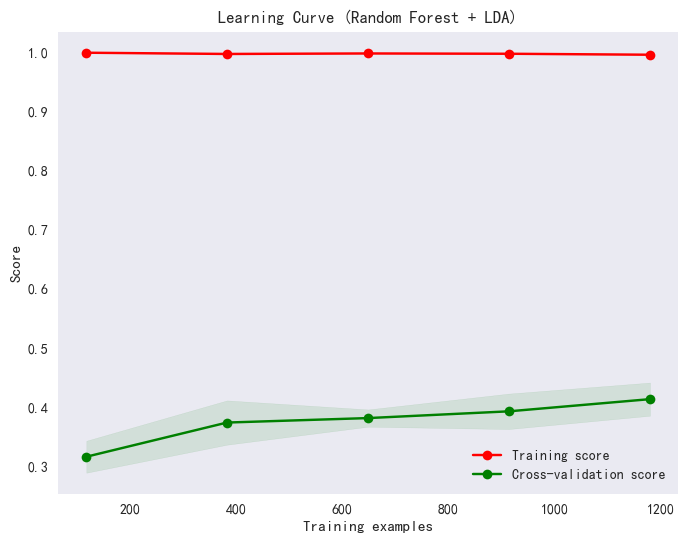


--- Classification Report (Precision, Recall, F1) ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.36      0.40      0.38        68
Frontotemporal Dementia       0.57      0.53      0.55        59
     Lewy Body Dementia       0.46      0.38      0.41        64
    Parkinson's Disease       0.37      0.37      0.37        68
      Vascular Dementia       0.49      0.56      0.52        70

               accuracy                           0.44       329
              macro avg       0.45      0.44      0.45       329
           weighted avg       0.45      0.44      0.44       329



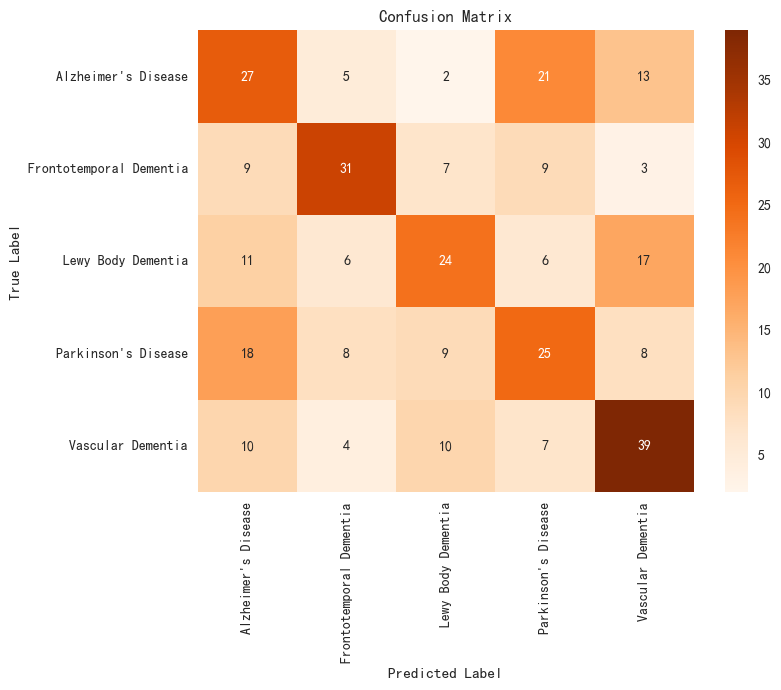

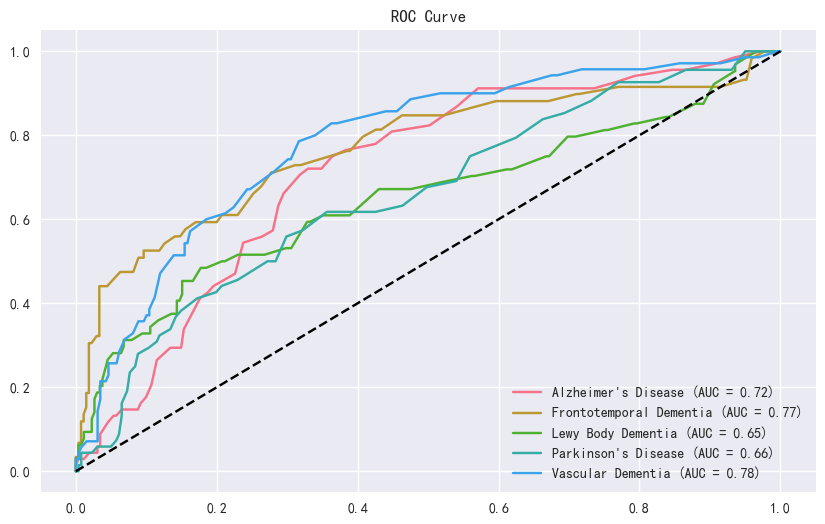


Step 6: Error Analysis - Common Words in Misclassified Docs...
Found 183 misclassified samples.

Top 20 Common Words in Misclassified Documents:
['disease', 'patient', 'study', 'brain', 'cognitive', 'result', 'group', 'method', 'protein', 'clinical', 'using', 'function', 'model', 'neurodegenerative', 'symptom', 'control', 'associated', 'level', 'related', 'amyloid']
Note: If generic medical terms (e.g., 'patient', 'study') appear here, they might be noise.

--- Misclassification Examples ---
[Case 1] True: Parkinson's Disease | Pred: Alzheimer's Disease
Content: vaccine promising therapy treatment chronic condition pruritus il identified important mediator itch targeting il signaling immunotherapy cp effective...
[Case 2] True: Alzheimer's Disease | Pred: Vascular Dementia
Content: objective increasing focus [DISEASE] [DISEASE] aging research identify transitional cognitive decline one mean indexing change time serial cognitive e...

Step 7: SHAP Analysis (Topic Contribution)...
Displ

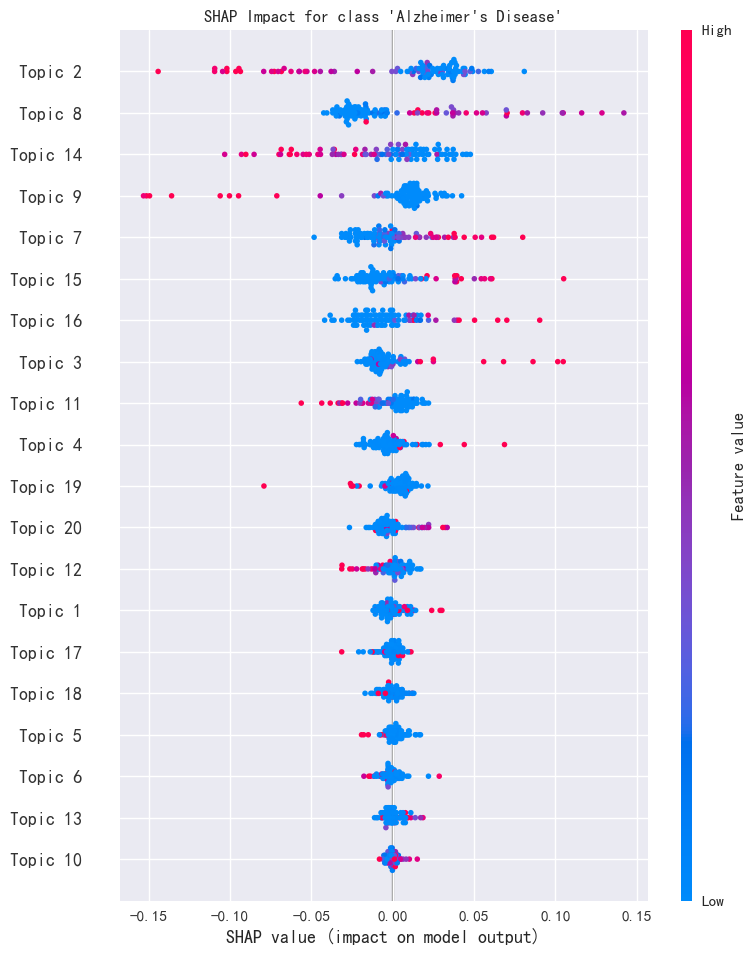

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import shap
from collections import Counter
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
# 支持中文显示 (如果需要)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理 (Data Loading & Preprocessing)
# ==========================================
print("Step 1: Loading Data...")
try:
    df = pd.read_csv('../cleaned_data.csv')
except FileNotFoundError:
    df = pd.read_csv('cleaned_data.csv') # Fallback if running from root

df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# 标签编码 (Label Encoding)
# 使用 LabelEncoder 将字符串标签转换为 0-(N-1) 的整数，这对某些分析 (如 SHAP, XGBoost) 是必须的
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
label_names = le.classes_
print(f"Classes: {label_names}")

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], 
    test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 2. 特征工程: LDA (Feature Engineering)
# ==========================================
print("Step 2: Extracting LDA Features...")
# 2.1 词频向量化 (LDA 需要 Count 矩阵)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf_train = tf_vectorizer.fit_transform(X_train_raw)
tf_test = tf_vectorizer.transform(X_test_raw)

# 2.2 LDA 模型训练
n_topics = 20
print(f"Training LDA with {n_topics} topics...")
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=42, n_jobs=-1)
X_train_features = lda.fit_transform(tf_train)
X_test_features = lda.transform(tf_test)

feature_names_lda = [f"Topic {i+1}" for i in range(n_topics)]
print(f"LDA Feature Matrix Shape: {X_train_features.shape}")

# 打印主题关键词 Preview
tf_feature_names = tf_vectorizer.get_feature_names_out()
print("\n--- LDA Topics Preview (Top 5 Words) ---")
for topic_idx, topic in enumerate(lda.components_[:5]):
    top_words = [tf_feature_names[i] for i in topic.argsort()[:-6:-1]]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

# ==========================================
# 3. 模型训练: Random Forest (Training)
# ==========================================
print("\nStep 3: Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 3.1 十折交叉验证 (10-Fold CV)
print("Running 10-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_features, y_train, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f} (Lower is more robust)")

# 全量训练
rf_model.fit(X_train_features, y_train)

# ==========================================
# 4. 偏差与变异性分析 (Bias vs Variance)
# ==========================================
print("\nStep 4: Plotting Learning Curves...")
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(rf_model, "Learning Curve (Random Forest + LDA)", X_train_features, y_train, cv=cv, n_jobs=-1)

# ==========================================
# 5. 评估与可视化 (Evaluation)
# ==========================================
y_pred = rf_model.predict(X_test_features)
y_prob = rf_model.predict_proba(X_test_features)

print("\n--- Classification Report (Precision, Recall, F1) ---")
print(classification_report(y_test, y_pred, target_names=label_names))

# 5.1 混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 5.2 ROC 曲线
plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test).values
# 兼容不同类别数量处理
if y_test_bin.shape[1] == len(label_names):
    for i, class_label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ==========================================
# 6. 误差分析: 特征层面的错误溯源 (Error Analysis)
# ==========================================
print("\nStep 6: Error Analysis - Common Words in Misclassified Docs...")
# 找出预测错误的样本索引
misclassified_indices = np.where(y_test != y_pred)[0]

if len(misclassified_indices) > 0:
    print(f"Found {len(misclassified_indices)} misclassified samples.")
    
    # 提取错误样本的原始文本 (利用索引映射回 iloc)
    error_docs = X_test_raw.iloc[misclassified_indices]
    error_true_label_ids = y_test.iloc[misclassified_indices]
    error_pred_label_ids = y_pred[misclassified_indices]
    
    # 使用 CountVectorizer 提取错误样本中的高频词 (Top 20)
    # 排除停用词，寻找共性干扰词
    error_cv = CountVectorizer(stop_words='english', max_features=20)
    try:
        error_counts = error_cv.fit_transform(error_docs)
        error_words = error_cv.get_feature_names_out()
        error_word_freq = np.asarray(error_counts.sum(axis=0)).flatten()
        
        error_top_words = dict(zip(error_words, error_word_freq))
        sorted_error_words = sorted(error_top_words.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nTop 20 Common Words in Misclassified Documents:")
        print([w for w, f in sorted_error_words])
        print("Note: If generic medical terms (e.g., 'patient', 'study') appear here, they might be noise.")
        
    except ValueError:
        print("Not enough text in error samples to extract vocabulary.")

    # 打印 2 个具体案例进行人工检查
    print("\n--- Misclassification Examples ---")
    for i in range(min(2, len(misclassified_indices))):
        idx_in_test = misclassified_indices[i]
        true_lbl = label_names[error_true_label_ids.iloc[i]]
        pred_lbl = label_names[error_pred_label_ids[i]]
        text_snippet = X_test_raw.iloc[idx_in_test][:150].replace('\n', ' ')
        print(f"[Case {i+1}] True: {true_lbl} | Pred: {pred_lbl}")
        print(f"Content: {text_snippet}...")
else:
    print("Perfect accuracy! No errors to analyze.")

# ==========================================
# 7. 可解释性: SHAP 拆解黑盒 (Explainability)
# ==========================================
print("\nStep 7: SHAP Analysis (Topic Contribution)...")
try:
    # Random Forest 应当使用 TreeExplainer
    explainer = shap.TreeExplainer(rf_model)
    
    # 为了速度，只计算测试集的一小部分样本
    sample_size = min(100, X_test_features.shape[0])
    X_shap_sample = X_test_features[:sample_size]
    
    # 计算 SHAP 值
    # 对于多分类问题，shap_values 通常是一个列表 [class_0_shap, class_1_shap, ...]
    shap_values = explainer.shap_values(X_shap_sample)
    
    # 获取第一个类别的 SHAP 值进行展示 (通常是按 label_names 顺序)
    target_class_idx = 0
    target_class_name = label_names[target_class_idx]
    
    if isinstance(shap_values, list):
        sv_to_plot = shap_values[target_class_idx]
    else:
        # 新版 shap 或某些配置下可能是 ndarray (n_samples, n_features, n_classes)
        sv_to_plot = shap_values[:, :, target_class_idx]

    print(f"Displaying SHAP Summary Plot for Class: {target_class_name}")
    print("Note: Features are LDA Topics. High Red value = High Topic Weight in this doc.")
    
    shap.summary_plot(sv_to_plot, X_shap_sample, feature_names=feature_names_lda, show=False)
    plt.title(f"SHAP Impact for class '{target_class_name}'")
    plt.show()
    
except Exception as e:
    print(f"SHAP Analysis skipped due to error: {e}")